In [1]:
!pip install colossalai

     |████████████████████████████████| 256 kB 4.2 MB/s 
     |████████████████████████████████| 195 kB 36.1 MB/s 
     |████████████████████████████████| 224 kB 35.4 MB/s 
     |████████████████████████████████| 98 kB 4.4 MB/s 
     |████████████████████████████████| 596 kB 38.6 MB/s 
     |████████████████████████████████| 8.8 MB 15.4 MB/s 
     |████████████████████████████████| 461 kB 43.4 MB/s 
     |████████████████████████████████| 51 kB 5.5 MB/s 
  Created wheel for colossalai: filename=colossalai-0.1.1-cp37-cp37m-linux_x86_64.whl size=17146046 sha256=e4bd8dbfad6909e828e75658749a4f0f07ef3b5366ed4719dd5b80f017883465
  Stored in directory: /root/.cache/pip/wheels/b2/7a/a1/62e6c3722e0305168510c395571827390fc52b93539ab5a196
Successfully built colossalai
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import os
from pathlib import Path
import math
import colossalai
import torch
import torch.nn as nn
import torch.nn.functional as F
from colossalai.core import global_context as gpc
from colossalai.logging import get_dist_logger
from colossalai.nn import CosineAnnealingLR
from colossalai.nn.metric import Accuracy
from colossalai.trainer import Trainer, hooks
from colossalai.utils import MultiTimer, get_dataloader
from torchvision import transforms
from torchvision.datasets import MNIST
from tqdm import tqdm



class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits


config = {'BATCH_SIZE':128,'NUM_EPOCHS':5}
lrs_dict = {'sgd':0.2,'adam':0.005,'rmsprop':0.007}
optim, lr_sch = 'sgd', 'lambda'
lr = lrs_dict[optim]

colossalai.launch(config=config,rank=0,world_size=1,host='127.0.0.1',port=1234)

logger = get_dist_logger()

# build 

model = LeNet5(n_classes=10)

# build dataloaders
train_dataset = MNIST(
    root=Path('./tmp/'),
    download=True,
    transform = transforms.Compose([transforms.Resize((32, 32)),
                              transforms.ToTensor()])
)

test_dataset = MNIST(
    root=Path('./tmp/'),
    train=False,
    transform = transforms.Compose([transforms.Resize((32, 32)),
                              transforms.ToTensor()])
)


train_dataloader = get_dataloader(dataset=train_dataset,
                                  shuffle=True,
                                  batch_size=gpc.config.BATCH_SIZE,
                                  num_workers=1,
                                  pin_memory=True,
                                  )

test_dataloader = get_dataloader(dataset=test_dataset,
                                  add_sampler=False,
                                  batch_size=gpc.config.BATCH_SIZE,
                                  num_workers=1,
                                  pin_memory=True,
                                  )

# build criterion
criterion = torch.nn.CrossEntropyLoss()

# optimizer
def build_optim(model,optim):
    optimizers = {
        'sgd':torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4),
        'adam':torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4),
        'adamw': torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=5e-4),
        'rmsprop': torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay=5e-4)
    }
    return optimizers[optim]


optimizer = build_optim(model,optim)

#exponentially increase learning rate from low to high
def lrs(batch):
    low = math.log2(1e-5)
    high = math.log2(10)
    return 2**(low+(high-low)*batch/len(train_dataloader)/gpc.config.NUM_EPOCHS)




# lr_scheduler
def build_lr_sch(optimizer,lr_sch):
    lr_schs = { 'lambda': torch.optim.lr_scheduler.LambdaLR(optimizer, lrs),
                'exp': torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.9),
                'multistep':torch.optim.lr_scheduler.MultiStepLR(optimizer,[10,20],0.35)}
    return lr_schs[lr_sch]

lr_scheduler = build_lr_sch(optimizer,lr_sch)

engine, train_dataloader, test_dataloader, _ = colossalai.initialize(model,
                                                                    optimizer,
                                                                    criterion,
                                                                    train_dataloader,
                                                                    test_dataloader,
                                                                    )
# build a timer to measure time
timer = MultiTimer()

# create a trainer object
trainer = Trainer(
        engine=engine,
        timer=timer,
        logger=logger
    )

# define the hooks to attach to the trainer
hook_list = [
        hooks.LossHook(),
        hooks.LRSchedulerHook(lr_scheduler=lr_scheduler, by_epoch=True),
        # hooks.AccuracyHook(accuracy_func=Accuracy()),
        hooks.LogMetricByEpochHook(logger),
        hooks.LogMemoryByEpochHook(logger),
        hooks.LogTimingByEpochHook(timer, logger),

        # you can uncomment these lines if you wish to use them
        hooks.TensorboardHook(log_dir='./tb_logs_{}_{}_{}_2'.format(optim,lr_sch,lr), ranks=[0]),
        # hooks.SaveCheckpointHook(checkpoint_dir='./ckpt')
    ]

# start training
trainer.fit(
        train_dataloader=train_dataloader,
        epochs=gpc.config.NUM_EPOCHS,
        test_dataloader=test_dataloader,
        test_interval=1,
        hooks=hook_list,
        display_progress=True
    )


# for epoch in range(gpc.config.NUM_EPOCHS):
#     for data, label in train_dataloader:
#         engine.zero_grad()
#         output = engine(data)
#         loss = engine.criterion(output, label)
#         engine.backward(loss)
#         engine.step()
    


[04/01/22 09:33:30] INFO     colossalai -                             ]8;id=523534;file:///usr/local/lib/python3.7/dist-packages/torch/distributed/distributed_c10d.py\distributed_c10d.py]8;;\:]8;id=619167;file:///usr/local/lib/python3.7/dist-packages/torch/distributed/distributed_c10d.py#217\217]8;;\
                             torch.distributed.distributed_c10d -                            
                             2022-04-01 09:33:30,040 INFO: Added key:                        
                             store_based_barrier_key:1 to store for                          
                             rank: 0                                                         

                    INFO     colossalai -                             ]8;id=781655;file:///usr/local/lib/python3.7/dist-packages/torch/distributed/distributed_c10d.py\distributed_c10d.py]8;;\:]8;id=595555;file:///usr/local/lib/python3.7/dist-packages/torch/distributed/distributed_c10d.py#252\252]8;;\
                             torch.distributed.distributed_c10d -                            
                             2022-04-01 09:33:30,050 INFO: Rank 0:                           
                             Completed store-based barrier for                               
                             key:store_based_barrier_key:1 with 1                            
                             nodes.                                                          

                    INFO     colossalai -                             ]8;id=594250;file:///usr/local/lib/python3.7/dist-packages/torch/distributed/distributed_c10d.py\distributed_c10d.py]8;;\:]8;id=744100;file:///usr/local/lib/python3.7/dist-packages/torch/distributed/distributed_c10d.py#217\217]8;;\
                             torch.distributed.distributed_c10d -                            
                             2022-04-01 09:33:30,056 INFO: Added key:                        
                             store_based_barrier_key:2 to store for                          
                             rank: 0                                                         

                    INFO     colossalai -                             ]8;id=106024;file:///usr/local/lib/python3.7/dist-packages/torch/distributed/distributed_c10d.py\distributed_c10d.py]8;;\:]8;id=316191;file:///usr/local/lib/python3.7/dist-packages/torch/distributed/distributed_c10d.py#252\252]8;;\
                             torch.distributed.distributed_c10d -                            
                             2022-04-01 09:33:30,065 INFO: Rank 0:                           
                             Completed store-based barrier for                               
                             key:store_based_barrier_key:2 with 1                            
                             nodes.                                                          

                    INFO     colossalai -                             ]8;id=605821;file:///usr/local/lib/python3.7/dist-packages/torch/distributed/distributed_c10d.py\distributed_c10d.py]8;;\:]8;id=922067;file:///usr/local/lib/python3.7/dist-packages/torch/distributed/distributed_c10d.py#217\217]8;;\
                             torch.distributed.distributed_c10d -                            
                             2022-04-01 09:33:30,074 INFO: Added key:                        
                             store_based_barrier_key:3 to store for                          
                             rank: 0                                                         

                    INFO     colossalai -                             ]8;id=302121;file:///usr/local/lib/python3.7/dist-packages/torch/distributed/distributed_c10d.py\distributed_c10d.py]8;;\:]8;id=330344;file:///usr/local/lib/python3.7/dist-packages/torch/distributed/distributed_c10d.py#252\252]8;;\
                             torch.distributed.distributed_c10d -                            
                             2022-04-01 09:33:30,080 INFO: Rank 0:                           
                             Completed store-based barrier for                               
                             key:store_based_barrier_key:3 with 1                            
                             nodes.                                                          

                    INFO     colossalai -                             ]8;id=642176;file:///usr/local/lib/python3.7/dist-packages/torch/distributed/distributed_c10d.py\distributed_c10d.py]8;;\:]8;id=321586;file:///usr/local/lib/python3.7/dist-packages/torch/distributed/distributed_c10d.py#217\217]8;;\
                             torch.distributed.distributed_c10d -                            
                             2022-04-01 09:33:30,089 INFO: Added key:                        
                             store_based_barrier_key:4 to store for                          
                             rank: 0                                                         

                    INFO     colossalai -                             ]8;id=879086;file:///usr/local/lib/python3.7/dist-packages/torch/distributed/distributed_c10d.py\distributed_c10d.py]8;;\:]8;id=394663;file:///usr/local/lib/python3.7/dist-packages/torch/distributed/distributed_c10d.py#252\252]8;;\
                             torch.distributed.distributed_c10d -                            
                             2022-04-01 09:33:30,094 INFO: Rank 0:                           
                             Completed store-based barrier for                               
                             key:store_based_barrier_key:4 with 1                            
                             nodes.                                                          

                    INFO     colossalai - colossalai - 2022-04-01 09:33:30,105  ]8;id=454070;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=576464;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: process rank 0 is bound to device 0                       

                    INFO     colossalai - colossalai - 2022-04-01 09:33:30,143  ]8;id=835769;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=20063;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: initialized seed on rank 0, numpy: 1024,                  
                             python random: 1024, ParallelMode.DATA: 1024,                   
                             ParallelMode.TENSOR: 1024,the default parallel                  
                             seed is ParallelMode.DATA.                                      

                    INFO     colossalai - colossalai - 2022-04-01 09:33:30,148  ]8;id=506985;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=408344;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#113\113]8;;\
                             INFO: Distributed environment is initialized, data              
                             parallel size: 1, pipeline parallel size: 1,                    
                             tensor parallel size: 1                                         

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting tmp/MNIST/raw/train-images-idx3-ubyte.gz to tmp/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting tmp/MNIST/raw/train-labels-idx1-ubyte.gz to tmp/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting tmp/MNIST/raw/t10k-images-idx3-ubyte.gz to tmp/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting tmp/MNIST/raw/t10k-labels-idx1-ubyte.gz to tmp/MNIST/raw



[04/01/22 09:33:31] INFO     colossalai - colossalai - 2022-04-01 09:33:31,622  ]8;id=338916;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=869699;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#113\113]8;;\
                             INFO:                                                           
                             ========== Your Config ========                                 
                             {'BATCH_SIZE': 128, 'NUM_EPOCHS': 5}                            
                             ================================                                
                                                                                             

                    INFO     colossalai - colossalai - 2022-04-01 09:33:31,630  ]8;id=831130;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=912715;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#113\113]8;;\
                             INFO: cuDNN benchmark = True, deterministic =                   
                             False                                                           

[04/01/22 09:33:39] WARNING  colossalai - colossalai - 2022-04-01 09:33:39,920  ]8;id=545030;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=105313;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             WARNING: Initializing an non ZeRO model with                    
                             optimizer class                                                 

                    WARNING  colossalai - colossalai - 2022-04-01 09:33:39,925  ]8;id=466742;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=537792;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#113\113]8;;\
                             WARNING: No PyTorch DDP or gradient handler is set              
                             up, please make sure you do not need to all-reduce              
                             the gradients after a training step.                            

[04/01/22 09:33:42] INFO     colossalai - colossalai - 2022-04-01 09:33:42,782  ]8;id=383671;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=847219;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#113\113]8;;\
                             INFO: Using LossHook for training, priority = 0                 

                    INFO     colossalai - colossalai - 2022-04-01 09:33:42,788  ]8;id=756882;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=846255;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#113\113]8;;\
                             INFO: Using LRSchedulerHook for training, priority              
                             = 1                                                             

                    INFO     colossalai - colossalai - 2022-04-01 09:33:42,792  ]8;id=750747;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=386742;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#113\113]8;;\
                             INFO: Using LogMetricByEpochHook for training,                  
                             priority = 10                                                   

                    INFO     colossalai - colossalai - 2022-04-01 09:33:42,798  ]8;id=407266;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=832621;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#113\113]8;;\
                             INFO: Using LogMemoryByEpochHook for training,                  
                             priority = 10                                                   

                    INFO     colossalai - colossalai - 2022-04-01 09:33:42,804  ]8;id=100681;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=745997;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#113\113]8;;\
                             INFO: Using LogTimingByEpochHook for training,                  
                             priority = 10                                                   

                    INFO     colossalai - colossalai - 2022-04-01 09:33:42,810  ]8;id=781049;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=916139;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#113\113]8;;\
                             INFO: Using TensorboardHook for training, priority              
                             = 10                                                            

                    INFO     colossalai - colossalai - 2022-04-01 09:33:42,816  ]8;id=146962;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=836397;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#113\113]8;;\
                             INFO: Lower value means higher priority for                     
                             calling hook function                                           

[04/01/22 09:33:44] INFO     colossalai - colossalai - 2022-04-01 09:33:44,970  ]8;id=408446;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=107259;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: Before-train: GPU: allocated 0.24 MB, max                 
                             allocated 0.24 MB, cached: 2.0 MB, max cached: 2.0              
                             MB                                                              

[Epoch 0 / Train]: 100%|██████████| 469/469 [00:13<00:00, 33.79it/s]


[04/01/22 09:33:59] INFO     colossalai - colossalai - 2022-04-01 09:33:59,008  ]8;id=429527;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=162597;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 0 / Train]: Loss = 2.3105 | LR =                   
                             2.0118e-06                                                      

                    INFO     colossalai - colossalai - 2022-04-01 09:33:59,026  ]8;id=457398;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=496973;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 0 / Train]: GPU: allocated 4.71 MB,                
                             max allocated 88.39 MB, cached: 26.0 MB, max                    
                             cached: 108.0 MB                                                

                    INFO     colossalai - colossalai - 2022-04-01 09:33:59,034  ]8;id=467890;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=770472;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 0 / Train]: Train-epoch: last = 13.88              
                             s, mean = 13.88 s | Train-step: last = 0.084076 s,              
                             mean = 0.026718 s | #steps/epoch = 469                          

[Epoch 0 / Test]: 100%|██████████| 79/79 [00:02<00:00, 37.47it/s]


[04/01/22 09:34:01] INFO     colossalai - colossalai - 2022-04-01 09:34:01,231  ]8;id=550437;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=884148;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 0 / Test]: Loss = 2.3105                           

                    INFO     colossalai - colossalai - 2022-04-01 09:34:01,242  ]8;id=966525;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=364022;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 0 / Test]: Test-epoch: last = 2.1021               
                             s, mean = 2.1021 s | Test-step: last = 0.019053 s,              
                             mean = 0.024119 s                                               

                    INFO     colossalai - colossalai - 2022-04-01 09:34:01,256  ]8;id=646487;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=947990;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 0 / Test]: GPU: allocated 0.72 MB,                 
                             max allocated 17.82 MB, cached: 24.0 MB, max                    
                             cached: 26.0 MB                                                 

[Epoch 1 / Train]: 100%|██████████| 469/469 [00:13<00:00, 34.27it/s]


[04/01/22 09:34:15] INFO     colossalai - colossalai - 2022-04-01 09:34:15,049  ]8;id=637420;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=92566;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 1 / Train]: Loss = 2.3104 | LR =                   
                             2.0237e-06                                                      

                    INFO     colossalai - colossalai - 2022-04-01 09:34:15,058  ]8;id=36874;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=87591;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 1 / Train]: GPU: allocated 4.71 MB,                
                             max allocated 18.28 MB, cached: 30.0 MB, max                    
                             cached: 30.0 MB                                                 

                    INFO     colossalai - colossalai - 2022-04-01 09:34:15,067  ]8;id=667345;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=807369;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 1 / Train]: Train-epoch: last =                    
                             13.681 s, mean = 13.681 s | Train-step: last =                  
                             0.012244 s, mean = 0.026481 s | #steps/epoch = 469              

[Epoch 1 / Test]: 100%|██████████| 79/79 [00:02<00:00, 37.43it/s]


[04/01/22 09:34:17] INFO     colossalai - colossalai - 2022-04-01 09:34:17,274  ]8;id=86073;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=107367;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 1 / Test]: Loss = 2.3103                           

                    INFO     colossalai - colossalai - 2022-04-01 09:34:17,283  ]8;id=379642;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=722727;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 1 / Test]: Test-epoch: last = 2.1164               
                             s, mean = 2.1164 s | Test-step: last = 0.0035448                
                             s, mean = 0.024317 s                                            

                    INFO     colossalai - colossalai - 2022-04-01 09:34:17,297  ]8;id=350587;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=914387;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 1 / Test]: GPU: allocated 0.72 MB,                 
                             max allocated 5.82 MB, cached: 30.0 MB, max                     
                             cached: 30.0 MB                                                 

[Epoch 2 / Train]: 100%|██████████| 469/469 [00:13<00:00, 34.22it/s]


[04/01/22 09:34:31] INFO     colossalai - colossalai - 2022-04-01 09:34:31,106  ]8;id=3561;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=388801;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 2 / Train]: Loss = 2.3102 | LR =                   
                             2.0357e-06                                                      

                    INFO     colossalai - colossalai - 2022-04-01 09:34:31,114  ]8;id=971517;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=315445;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 2 / Train]: GPU: allocated 4.71 MB,                
                             max allocated 18.28 MB, cached: 30.0 MB, max                    
                             cached: 30.0 MB                                                 

                    INFO     colossalai - colossalai - 2022-04-01 09:34:31,120  ]8;id=191330;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=141390;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 2 / Train]: Train-epoch: last =                    
                             13.711 s, mean = 13.711 s | Train-step: last =                  
                             0.017474 s, mean = 0.026342 s | #steps/epoch = 469              

[Epoch 2 / Test]: 100%|██████████| 79/79 [00:02<00:00, 37.38it/s]


[04/01/22 09:34:33] INFO     colossalai - colossalai - 2022-04-01 09:34:33,328  ]8;id=167384;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=959325;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 2 / Test]: Loss = 2.3102                           

                    INFO     colossalai - colossalai - 2022-04-01 09:34:33,337  ]8;id=408057;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=299722;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 2 / Test]: Test-epoch: last = 2.1171               
                             s, mean = 2.1171 s | Test-step: last = 0.0033789                
                             s, mean = 0.024126 s                                            

                    INFO     colossalai - colossalai - 2022-04-01 09:34:33,348  ]8;id=168896;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=907314;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 2 / Test]: GPU: allocated 0.72 MB,                 
                             max allocated 5.82 MB, cached: 30.0 MB, max                     
                             cached: 30.0 MB                                                 

[Epoch 3 / Train]: 100%|██████████| 469/469 [00:13<00:00, 34.40it/s]


[04/01/22 09:34:47] INFO     colossalai - colossalai - 2022-04-01 09:34:47,079  ]8;id=95277;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=240130;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 3 / Train]: Loss = 2.3101 | LR =                   
                             2.0477e-06                                                      

                    INFO     colossalai - colossalai - 2022-04-01 09:34:47,091  ]8;id=860176;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=610902;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 3 / Train]: GPU: allocated 4.71 MB,                
                             max allocated 18.28 MB, cached: 30.0 MB, max                    
                             cached: 30.0 MB                                                 

                    INFO     colossalai - colossalai - 2022-04-01 09:34:47,101  ]8;id=126868;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=481816;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 3 / Train]: Train-epoch: last =                    
                             13.634 s, mean = 13.634 s | Train-step: last =                  
                             0.016884 s, mean = 0.026254 s | #steps/epoch = 469              

[Epoch 3 / Test]: 100%|██████████| 79/79 [00:02<00:00, 37.59it/s]


[04/01/22 09:34:49] INFO     colossalai - colossalai - 2022-04-01 09:34:49,298  ]8;id=714915;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=949050;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 3 / Test]: Loss = 2.31                             

                    INFO     colossalai - colossalai - 2022-04-01 09:34:49,308  ]8;id=588986;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=24862;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 3 / Test]: Test-epoch: last = 2.1047               
                             s, mean = 2.1047 s | Test-step: last = 0.0032606                
                             s, mean = 0.023978 s                                            

                    INFO     colossalai - colossalai - 2022-04-01 09:34:49,319  ]8;id=731619;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=430394;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 3 / Test]: GPU: allocated 0.72 MB,                 
                             max allocated 5.82 MB, cached: 30.0 MB, max                     
                             cached: 30.0 MB                                                 

[Epoch 4 / Train]: 100%|██████████| 469/469 [00:13<00:00, 34.26it/s]


[04/01/22 09:35:03] INFO     colossalai - colossalai - 2022-04-01 09:35:03,112  ]8;id=845059;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=22590;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 4 / Train]: Loss = 2.3099 | LR =                   
                             2.0598e-06                                                      

                    INFO     colossalai - colossalai - 2022-04-01 09:35:03,125  ]8;id=867384;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=22492;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 4 / Train]: GPU: allocated 4.71 MB,                
                             max allocated 18.28 MB, cached: 30.0 MB, max                    
                             cached: 30.0 MB                                                 

                    INFO     colossalai - colossalai - 2022-04-01 09:35:03,134  ]8;id=954487;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=920788;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 4 / Train]: Train-epoch: last = 13.69              
                             s, mean = 13.69 s | Train-step: last = 0.016477 s,              
                             mean = 0.026199 s | #steps/epoch = 469                          

[Epoch 4 / Test]: 100%|██████████| 79/79 [00:02<00:00, 36.70it/s]


[04/01/22 09:35:05] INFO     colossalai - colossalai - 2022-04-01 09:35:05,381  ]8;id=258997;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=788654;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 4 / Test]: Loss = 2.3098                           

                    INFO     colossalai - colossalai - 2022-04-01 09:35:05,391  ]8;id=942760;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=868513;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 4 / Test]: Test-epoch: last = 2.1564               
                             s, mean = 2.1564 s | Test-step: last = 0.0034952                
                             s, mean = 0.024943 s                                            

                    INFO     colossalai - colossalai - 2022-04-01 09:35:05,403  ]8;id=162409;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=984032;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 4 / Test]: GPU: allocated 0.72 MB,                 
                             max allocated 5.82 MB, cached: 30.0 MB, max                     
                             cached: 30.0 MB                                                 

In [ ]:
# !tensorboard dev list
!tensorboard dev upload --logdir tb_logs_rmsprop --name rmsprop

Upload started and will continue reading any new data as it's added to the logdir.

To stop uploading, press Ctrl-C.

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/qvuOPzMATNeMfja3tQ2jxw/

[2022-04-01T05:22:15] Started scanning logdir.
[2022-04-01T05:22:17] Total uploaded: 4695 scalars, 0 tensors, 0 binary objects


Interrupted. View your TensorBoard at https://tensorboard.dev/experiment/qvuOPzMATNeMfja3tQ2jxw/
Traceback (most recent call last):
  File "/usr/local/bin/tensorboard", line 8, in <module>
    sys.exit(run_main())
  File "/usr/local/lib/python3.7/dist-packages/tensorboard/main.py", line 46, in run_main
    app.run(tensorboard.main, flags_parser=tensorboard.configure)
  File "/usr/local/lib/python3.7/dist-packages/absl/app.py", line 312, in run
    _run_main(main, args)
  File "/usr/local/lib/python3.7/dist-packages/absl/app.py", line 258, in _run_main
    sys.exit(main(argv))
  File "/usr/local/lib/python3.7/dist-packages/tensorboard/p

In [3]:
import tensorboard as tb 
experiment_id = {'radam':'B7PlBgzCRmOILgg4gH4VAA', 
                 'adamw':'qf58dBdeSryZjwPUAPSrSQ',
                 'adam':'ivXiNcOmRtywgd02A2enNA',
                 'sgd': 'odKop8qQRuqbtaNpH55Ynw',
                 'rmsprop':'qvuOPzMATNeMfja3tQ2jxw'}

def get_lr_loss(experiment_id):
    experiment = tb.data.experimental.ExperimentFromDev(experiment_id)
    df = experiment.get_scalars()
    lrs = df[df['tag'] == 'LR/train'][['step','value']]
    loss_train = df[df['tag'] == 'Loss/train'][['step','value']]
    loss_vs_lr = lrs.merge(loss_train,on='step')
    return loss_vs_lr


[04/01/22 09:48:09] INFO     colossalai - absl - 2022-04-01 09:48:09,823   ]8;id=753229;file:///usr/local/lib/python3.7/dist-packages/tensorboard/uploader/server_info.py\server_info.py]8;;\:]8;id=352831;file:///usr/local/lib/python3.7/dist-packages/tensorboard/uploader/server_info.py#110\110]8;;\
                             INFO: Requested server info: <version:                          
                             "2.8.0"                                                         
                             plugin_specification {                                          
                               upload_plugins: "scalars"                                     
                             }                                                               
                             >                                                               

sgd lowest loss: 0.035266805440187454 lr: 0.19212420284748077


[04/01/22 09:48:10] INFO     colossalai - absl - 2022-04-01 09:48:10,877   ]8;id=29495;file:///usr/local/lib/python3.7/dist-packages/tensorboard/uploader/server_info.py\server_info.py]8;;\:]8;id=575821;file:///usr/local/lib/python3.7/dist-packages/tensorboard/uploader/server_info.py#110\110]8;;\
                             INFO: Requested server info: <version:                          
                             "2.8.0"                                                         
                             plugin_specification {                                          
                               upload_plugins: "scalars"                                     
                             }                                                               
                             >                                                               

adam lowest loss: 0.053520020097494125 lr: 0.004750716034322977


[04/01/22 09:48:11] INFO     colossalai - absl - 2022-04-01 09:48:11,908   ]8;id=401774;file:///usr/local/lib/python3.7/dist-packages/tensorboard/uploader/server_info.py\server_info.py]8;;\:]8;id=148601;file:///usr/local/lib/python3.7/dist-packages/tensorboard/uploader/server_info.py#110\110]8;;\
                             INFO: Requested server info: <version:                          
                             "2.8.0"                                                         
                             plugin_specification {                                          
                               upload_plugins: "scalars"                                     
                             }                                                               
                             >                                                               

adamw lowest loss: 0.03057222254574299 lr: 0.01666281558573246


[04/01/22 09:48:12] INFO     colossalai - absl - 2022-04-01 09:48:12,815   ]8;id=257361;file:///usr/local/lib/python3.7/dist-packages/tensorboard/uploader/server_info.py\server_info.py]8;;\:]8;id=475057;file:///usr/local/lib/python3.7/dist-packages/tensorboard/uploader/server_info.py#110\110]8;;\
                             INFO: Requested server info: <version:                          
                             "2.8.0"                                                         
                             plugin_specification {                                          
                               upload_plugins: "scalars"                                     
                             }                                                               
                             >                                                               

rmsprop lowest loss: 0.03814581409096718 lr: 0.006685900501906872


[04/01/22 09:48:13] INFO     colossalai - absl - 2022-04-01 09:48:13,685   ]8;id=783296;file:///usr/local/lib/python3.7/dist-packages/tensorboard/uploader/server_info.py\server_info.py]8;;\:]8;id=224946;file:///usr/local/lib/python3.7/dist-packages/tensorboard/uploader/server_info.py#110\110]8;;\
                             INFO: Requested server info: <version:                          
                             "2.8.0"                                                         
                             plugin_specification {                                          
                               upload_plugins: "scalars"                                     
                             }                                                               
                             >                                                               

radam lowest loss: 0.04059324413537979 lr: 0.006685900501906872


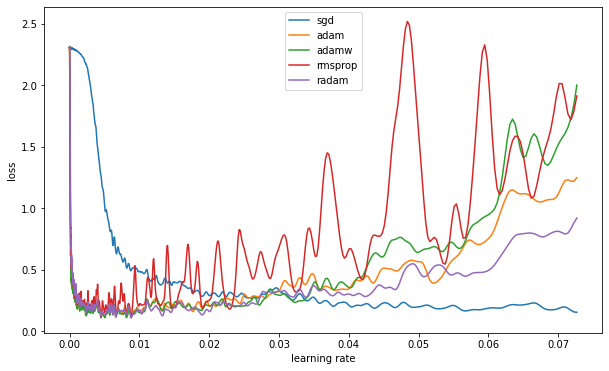

In [31]:
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.pyplot as plt
import numpy as np



fig = plt.figure(figsize=[10,6])
# loss_vs_lr_plot = plt.plot(loss_vs_lr['value_x'].to_list(),loss_vs_lr['value_y'].to_list())
for optim in ['sgd','adam','adamw','rmsprop','radam']:
    loss_vs_lr = get_lr_loss(experiment_id[optim]) 
    x,y = loss_vs_lr['value_x'].to_list(), loss_vs_lr['value_y'].to_list()
    ysmoothed = gaussian_filter1d(y, sigma=2)
    print(optim,'lowest loss:', np.min(np.array(y)), 'lr:',x[np.argmin(np.array(y))])
    plt.plot(x[:1900], ysmoothed[:1900], label=optim)
plt.xlabel('learning rate')
plt.ylabel('loss')
plt.legend()
plt.show()

In [49]:
from google.colab import drive, files

# drive.mount('./drive')
!pip freeze > requirements.txt 
files.download("requirements.txt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>